In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.4.1
Pandas Version: 1.4.4
Numpy Version: 1.20.3
System Version: 3.9.12 (main, Jun  1 2022, 11:38:51) 
[GCC 7.5.0]


In [2]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 1000
TRAIN_SPLIT = 20000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 4
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [3]:
df = pd.read_csv('./data/train.csv')
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())

DataFrame Shape: 29701 rows, 10 columns


,t,1,2,3,4,time,x,y,delta_x,delta_y
0,0.00,119.947865,102.751992,100.623908,101,0.00,15.860380,-23.297520,0.000000,0.000000
1,0.01,119.927054,102.738962,100.628316,101,0.01,15.860189,-23.298586,-0.000191,-0.001066
2,0.02,119.906244,102.725932,100.632724,101,0.02,15.859999,-23.299651,-0.000191,-0.001066
3,0.03,119.885434,102.712902,100.637131,101,0.03,15.859808,-23.300717,-0.000191,-0.001066
4,0.04,119.864623,102.699872,100.641539,101,0.04,15.859618,-23.301783,-0.000191,-0.001066


In [4]:
features_considered = ['1', '2', '3', 'x', 'y']

features = df[features_considered]
features.index = df['t']
features.head()

,1,2,3,x,y
t,,,,,
0.00,119.947865,102.751992,100.623908,15.860380,-23.297520
0.01,119.927054,102.738962,100.628316,15.860189,-23.298586
0.02,119.906244,102.725932,100.632724,15.859999,-23.299651
0.03,119.885434,102.712902,100.637131,15.859808,-23.300717
0.04,119.864623,102.699872,100.641539,15.859618,-23.301783


array([<AxesSubplot:xlabel='t'>, <AxesSubplot:xlabel='t'>,
       <AxesSubplot:xlabel='t'>, <AxesSubplot:xlabel='t'>,
       <AxesSubplot:xlabel='t'>], dtype=object)

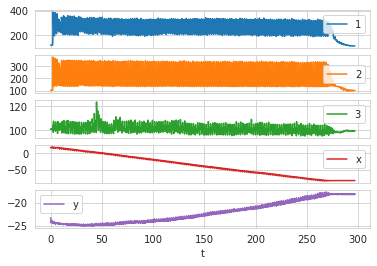

In [5]:
features.plot(subplots=True)

In [6]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

print(dataset.shape)
display(pd.DataFrame(dataset, columns = features.columns, index= features.index).head())

(29701, 5)


,1,2,3,x,y
t,,,,,
0.00,-2.582486,-1.171419,-0.432380,1.629950,0.250894
0.01,-2.582878,-1.171570,-0.430709,1.629941,0.249977
0.02,-2.583270,-1.171721,-0.429039,1.629933,0.249060
0.03,-2.583663,-1.171872,-0.427368,1.629924,0.248143
0.04,-2.584055,-1.172023,-0.425697,1.629916,0.247227


In [58]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    for i, (var, c) in enumerate(zip(features.columns[:5], ['b','r','g','y','c',])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()

In [59]:
past_history = 1000
future_target = 100
STEP = 6

x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:5], dataset[:,:5], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:5], dataset[:, :5],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [60]:
print (x_train_multi.shape,
       y_train_multi.shape,
       x_val_multi.shape,
       y_val_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target position to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(19000, 167, 5, 1, 1)
(19000, 100, 5, 1, 1)
(8601, 167, 5, 1, 1)
(8601, 100, 5, 1, 1)
Single window of past history : (167, 5, 1, 1)
Target position to predict : (100, 5, 1, 1)


In [61]:
BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

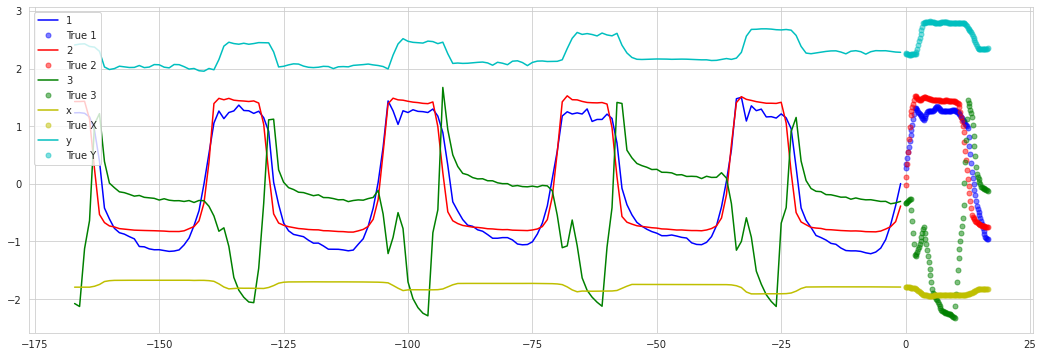

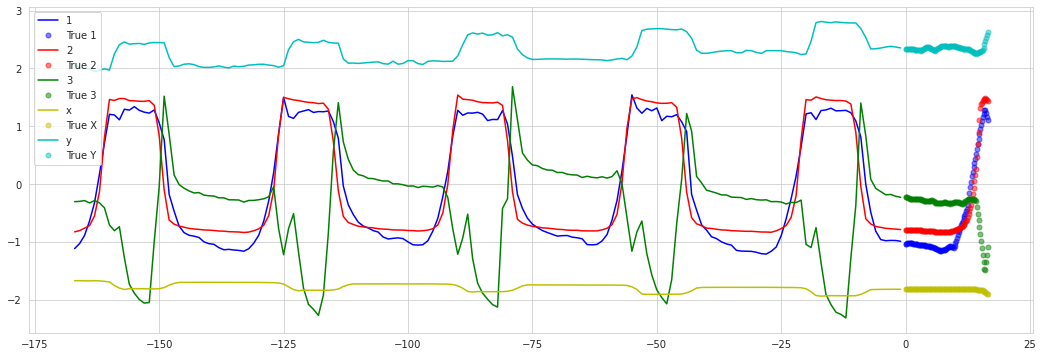

In [62]:
for x, y in val_data_multi.take(2):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.array([0]))

In [63]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):
    # COPY PASTA
    # https://github.com/niklascp/bus-arrival-convlstm/blob/master/jupyter/ConvLSTM_3x15min_10x64-5x64-10x64-5x64-Comparison.ipynb
    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

    # optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
    optimizer = tf.keras.optimizers.Adam()
    # optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

In [65]:
future_target = 100
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,:5], dataset[:,:5], 0,
                                                 TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,:5], dataset[:, :5],
                                             TRAIN_SPLIT, None, past_history, future_target, STEP)

BATCH_SIZE = 512

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [66]:
EPOCHS = 5
steps_per_epoch = 350
validation_steps = 500

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('multi-output-timesteps.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 167, 5, 1, 1)      4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 167, 5, 1, 64)     166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 167, 5, 1, 64)     0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 167, 5, 1, 64)     256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 5, 1, 64)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 1, 64)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 5, 1, 64)         

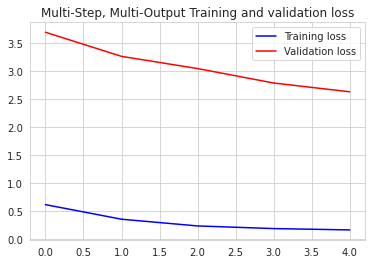

In [67]:
plot_train_history(history, 'Multi-Step, Multi-Output Training and validation loss')

(167, 5, 1, 1) (100, 5, 1, 1)


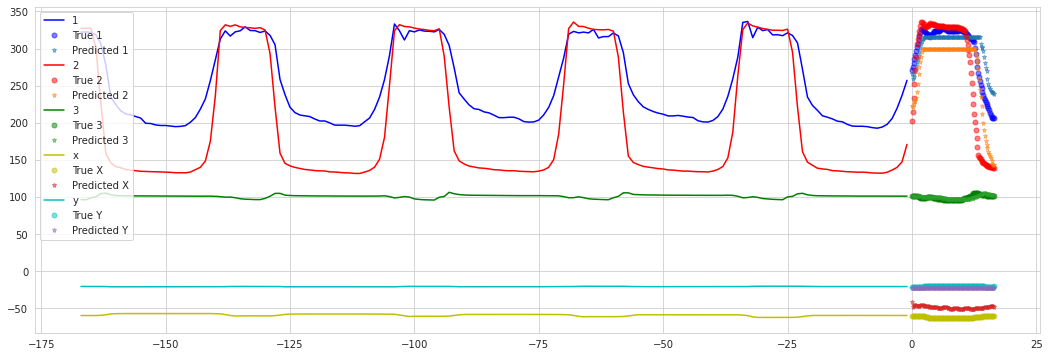

(167, 5, 1, 1) (100, 5, 1, 1)


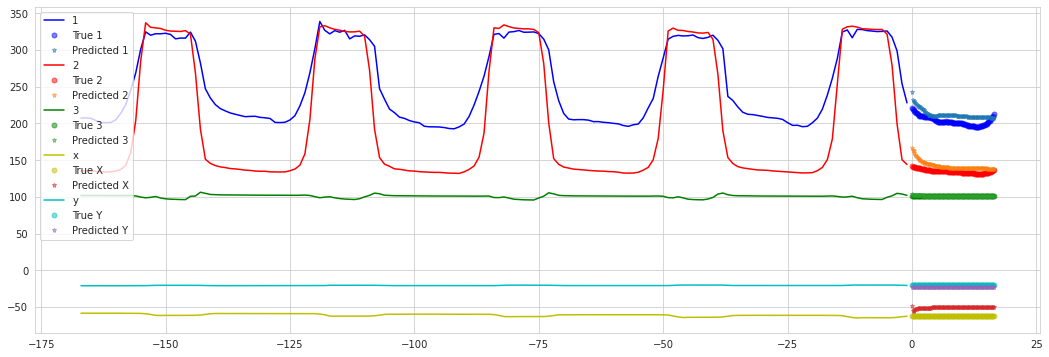

(167, 5, 1, 1) (100, 5, 1, 1)


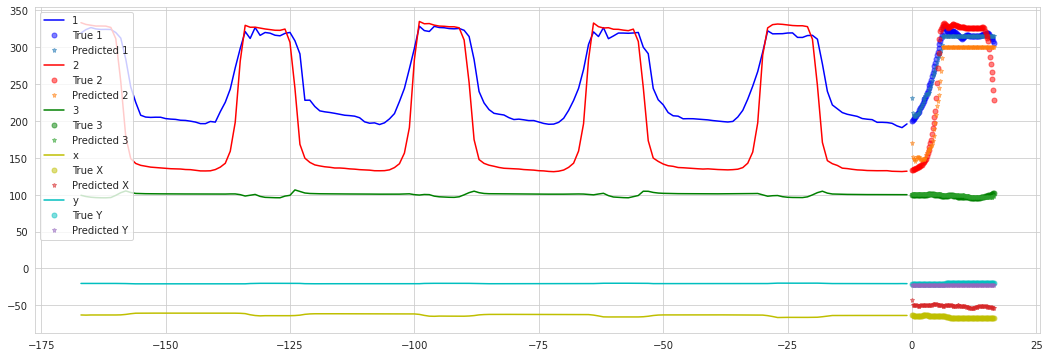

(167, 5, 1, 1) (100, 5, 1, 1)


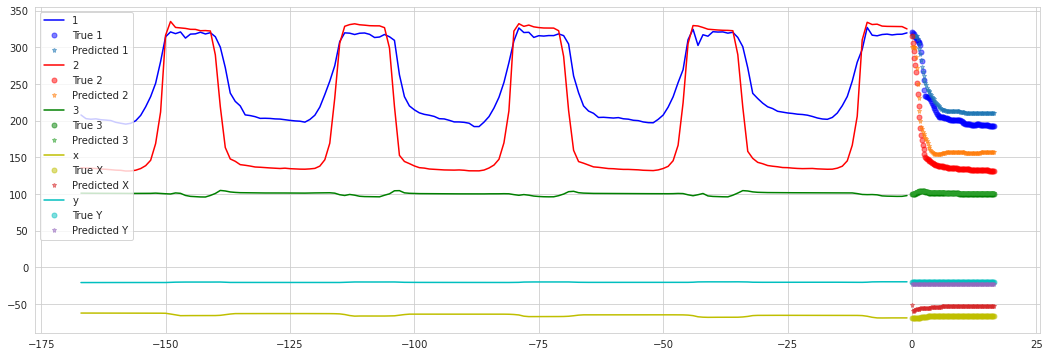

(167, 5, 1, 1) (100, 5, 1, 1)


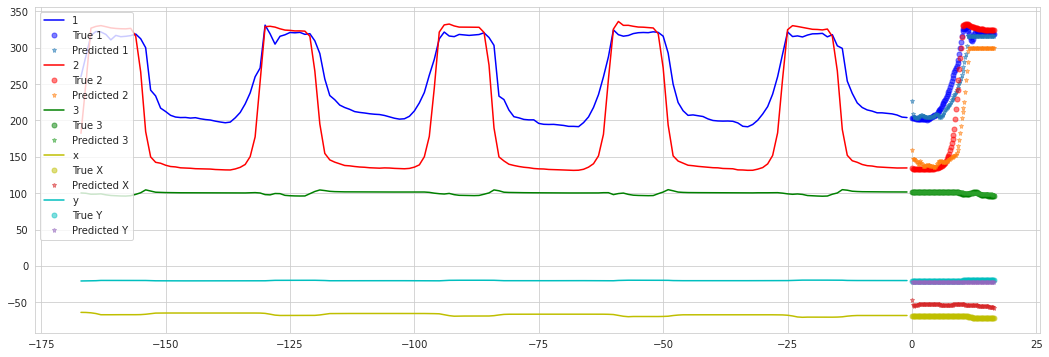

(167, 5, 1, 1) (100, 5, 1, 1)


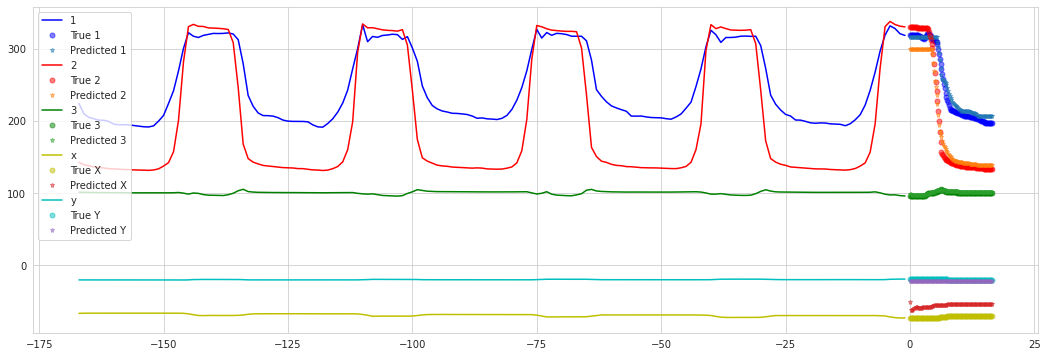

(167, 5, 1, 1) (100, 5, 1, 1)


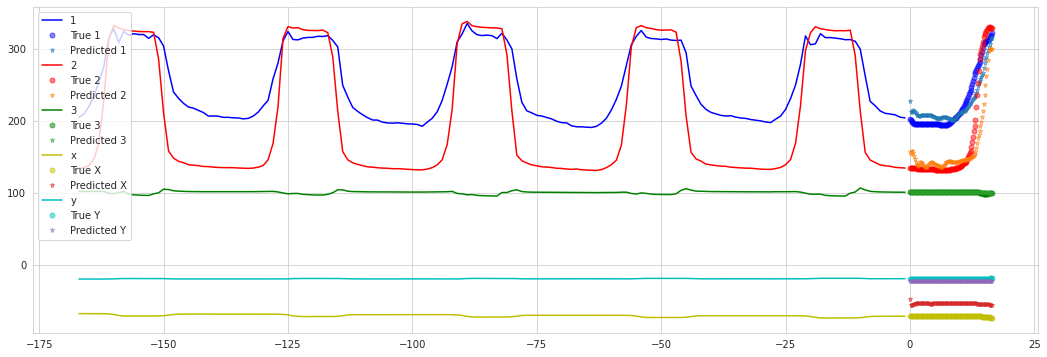

(167, 5, 1, 1) (100, 5, 1, 1)


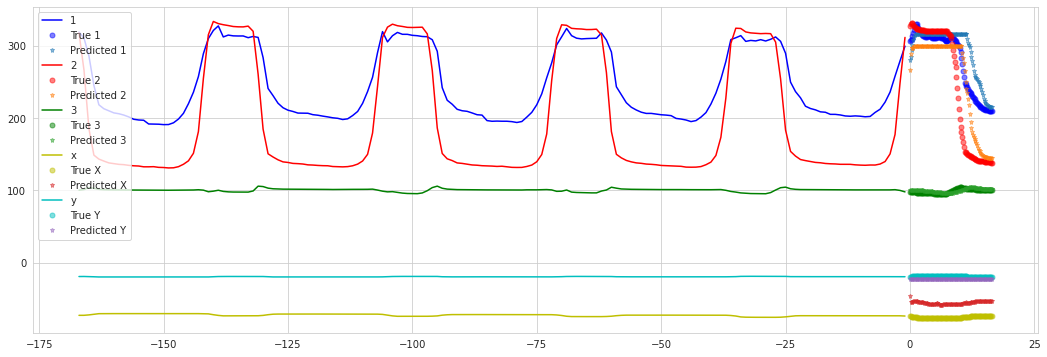

(167, 5, 1, 1) (100, 5, 1, 1)


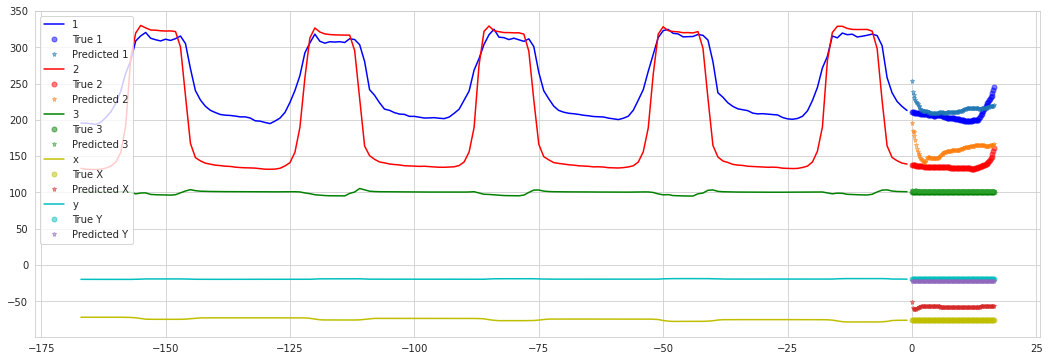

(167, 5, 1, 1) (100, 5, 1, 1)


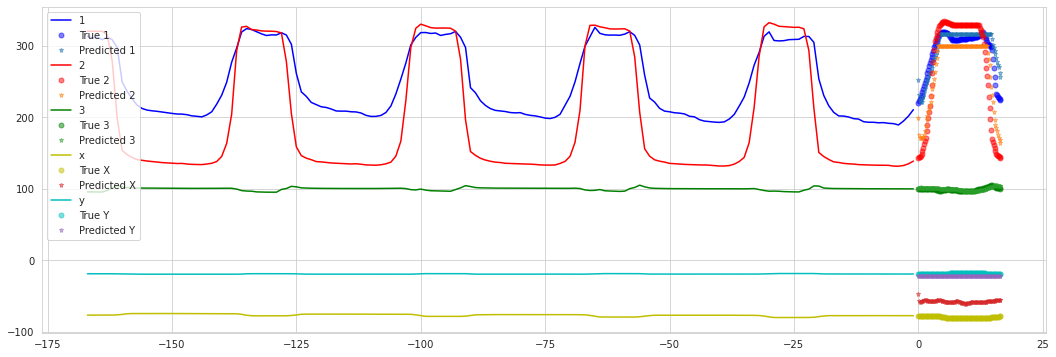

In [68]:
for x, y in val_data_multi.take(10):
    print(x[0].shape, y[0].shape)
    multi_step_output_plot(np.squeeze(x[0])*data_std+data_mean, np.squeeze(y[0])*data_std+data_mean, np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:]))*data_std+data_mean)

(167, 5, 1, 1) (72, 5, 1, 1)


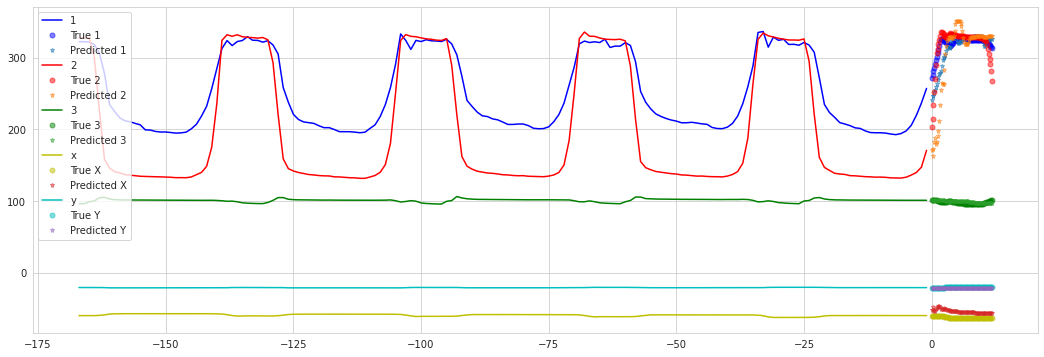

(167, 5, 1, 1) (72, 5, 1, 1)


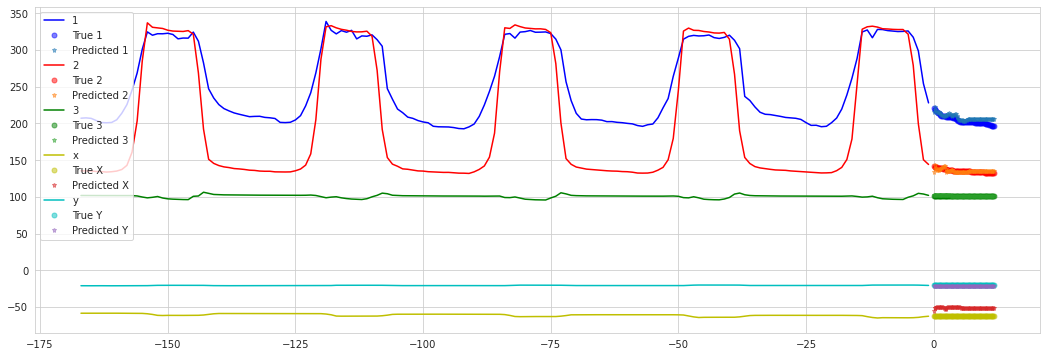

(167, 5, 1, 1) (72, 5, 1, 1)


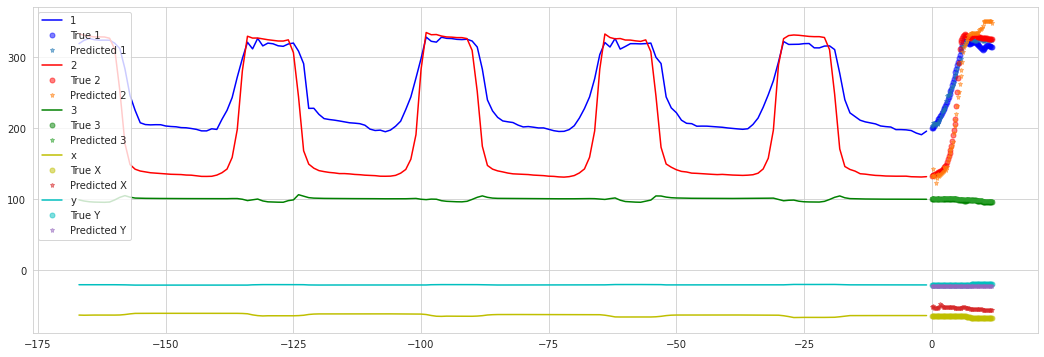

(167, 5, 1, 1) (72, 5, 1, 1)


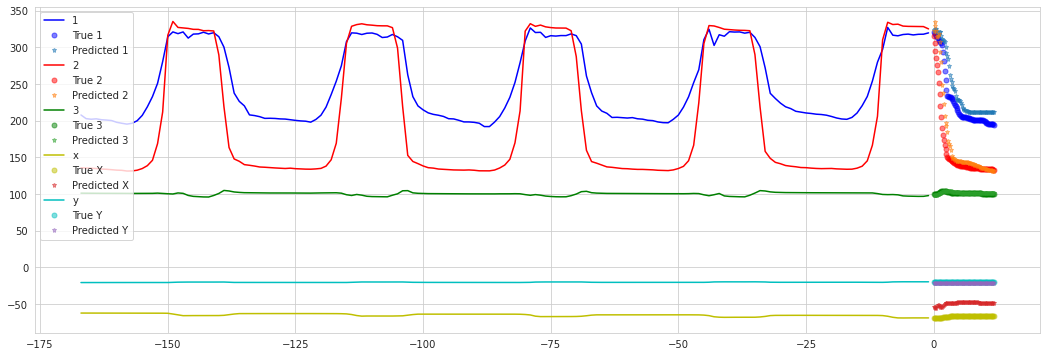

(167, 5, 1, 1) (72, 5, 1, 1)


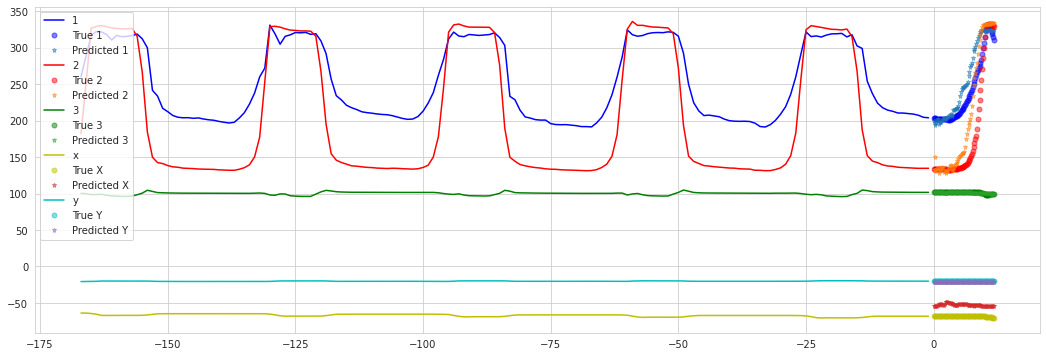

(167, 5, 1, 1) (72, 5, 1, 1)


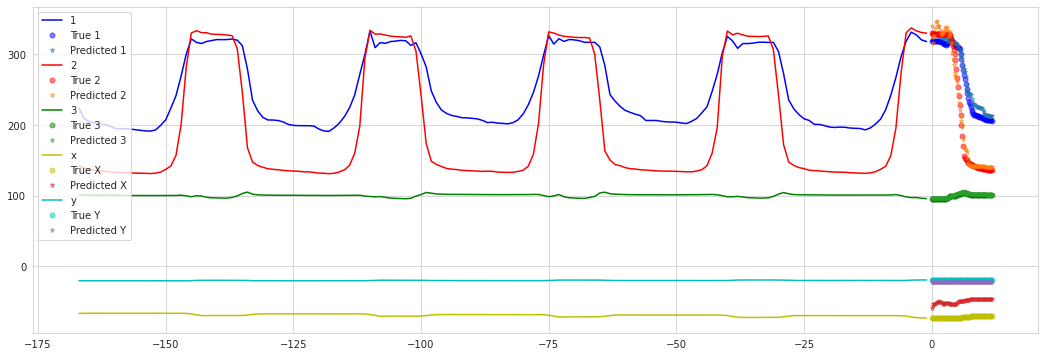

(167, 5, 1, 1) (72, 5, 1, 1)


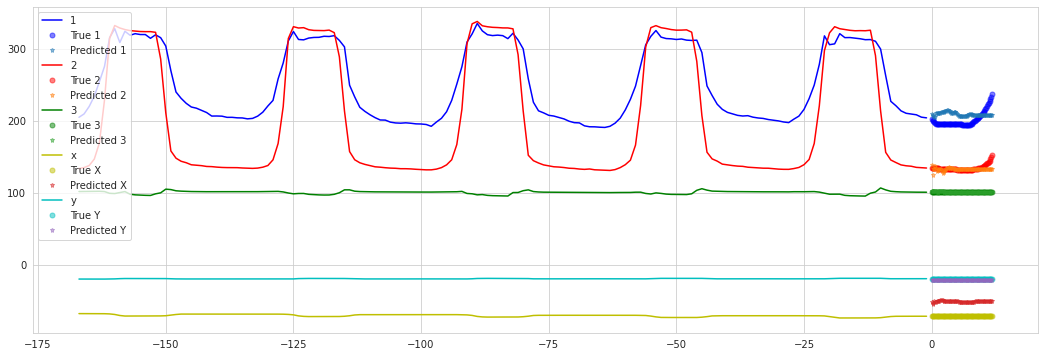

(167, 5, 1, 1) (72, 5, 1, 1)


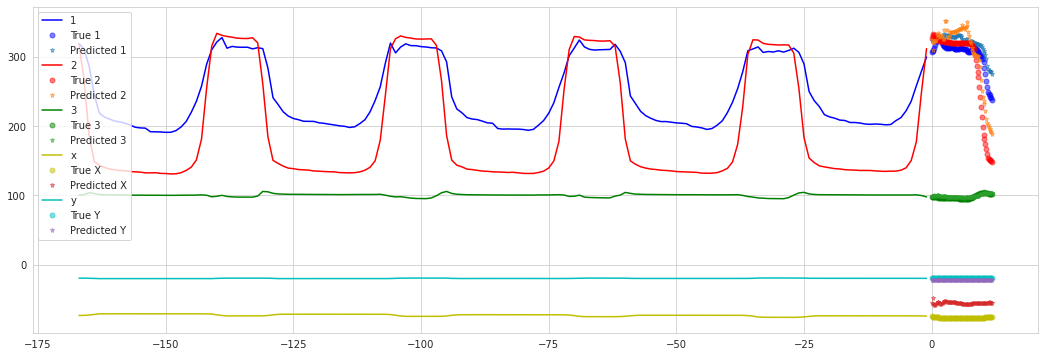

(167, 5, 1, 1) (72, 5, 1, 1)


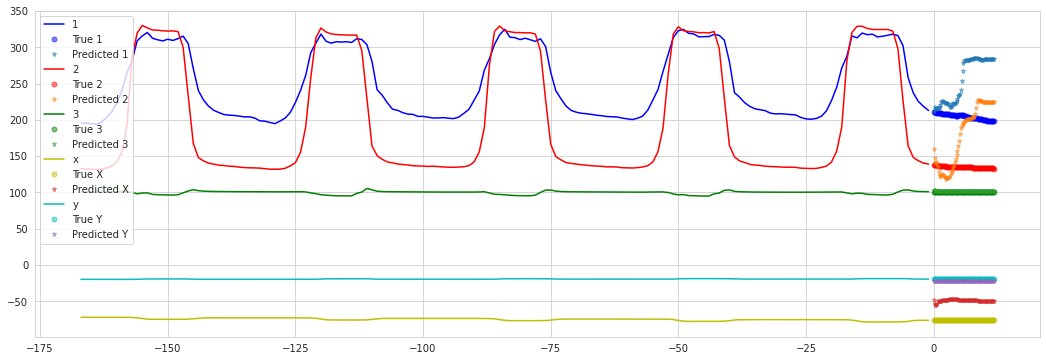

(167, 5, 1, 1) (72, 5, 1, 1)


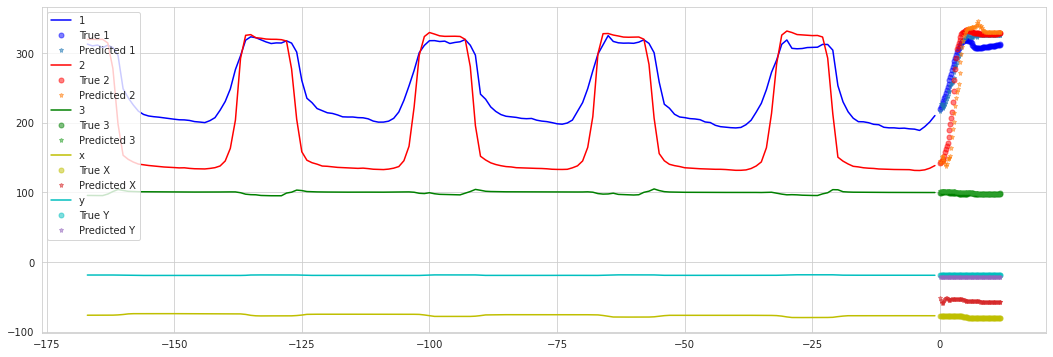

In [32]:
for x, y in val_data_multi.take(10):
    print(x[0].shape, y[0].shape)
    multi_step_output_plot(np.squeeze(x[0])*data_std+data_mean, np.squeeze(y[0])*data_std+data_mean, np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:]))*data_std+data_mean)